In [34]:
# import of necessary files from other folders

import os
import sys

path = os.path.abspath('')
base_path = path.split('/microbial_ecology_in_space')[0]
module_path = f'{base_path}/microbial_ecology_in_space/models/shared'
module_path_1 = f'{base_path}/microbial_ecology_in_space/models/well_mixed'

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path_1 not in sys.path:
    sys.path.append(module_path_1)

# libraries imports

import importlib
import numpy as np
import tempfile
import matplotlib.pyplot as plt

from IPython.display import Image, display
from PIL import Image
from scipy.integrate import solve_ivp

import visualize
import definitions
import well_mixed

importlib.reload(definitions)
importlib.reload(well_mixed)
importlib.reload(visualize)

<module 'visualize' from '/Users/federicasibilla/Documenti/Tesi/microbial_ecology_in_space/models/shared/visualize.py'>

# Consumer-Resource to Lotka-Volterra mapping

This notebook is intended as an exercise and a demonstration of how a consumer-resource model can be mapped to a LV one. It is then used specifically for the case of the famous two auxotrophs. 

## Theoretical background

We will now explain how the mapping is done in theory, to then demonstrate it in practice. First of all, it is usefull to write the equations of the model in the form of impact and sensitivity function:

$\frac{1}{s_{\alpha}}\frac{ds_{\alpha}}{dt}=g_{\alpha}(\mathbf{R})\\$
$\frac{d\mathbf{R}}{dt}=\sum_{\beta}s_{\beta}\mathbf{f}_{\beta}(\mathbf{R})+\mathbf{\sigma}$

Where $g$ are the sensitivity functions and $\mathbf{f}$ are the impact functions.

At the same time, the general LV model can be written as:

$\frac{1}{s_{\alpha}}\frac{ds_{\alpha}}{dt}=g_{\alpha}^0+\sum_{\beta}a_{\alpha\beta}s_{\beta}$

Where $a_{\alpha\beta}$ are the pair-wise interaction coefficients. Our goal here is to Start from a consumer resource model, and find the corresponding $a_{\alpha\beta}$ matrix such that the obtained LV model has the same steady state species abundances as the CR. This can be done through the fEO equation:

$\frac{1}{s_{\alpha}}\frac{ds_{\alpha}}{dt}=g_{\alpha}(\mathbf{R(0)})+\int_{0}^t\mathbf{\nabla}g_{\alpha}(\mathbf{R})\cdot\mathbf{\sigma}dt'+\sum_{\beta}\int_{0}^t\mathbf{\nabla}g_{\alpha}(\mathbf{R})\cdot\mathbf{f}_{\beta}(\mathbf{R})s_{\beta}dt'$

At equilibrium, the LHS of the equation is zero, abnd since the equation has to be valid for all $t$, this implies

$-\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{\sigma}(\mathbf{R}^*)=\sum_{\beta}\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{f}_{\beta}(\mathbf{R}^*)s_{\beta}$

In the same way, at equilibrium, GLV implies:

$-g_{\alpha}^0=\sum_{\beta}a_{\alpha\beta}s_{\beta}$

Which finally gives us the mapping:

$g_{\alpha}^0=\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{\sigma}(\mathbf{R}^*)\\$
$a_{\alpha\beta}=\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{f}_{\beta}(\mathbf{R}^*)$

## From our CR to impact and sensitivity functions

We want to write the model in terms of impact and sensitivity functions.


$\frac{dR_{\alpha}}{dt}=\frac{R_{\alpha}^0-R_{\alpha}}{\tau}-\sum_i s_{i}c_{i\alpha}\frac{R_{\alpha}}{1+R_{\alpha}}+\sum_{i,\beta}s_i c_{i\beta}\frac{R_{\beta}}{1+R_{\beta}}D_{\alpha\beta}\frac{w_{\alpha}}{w_{\beta}}l_{\beta}$

which transaltes in 

$\mathbf{f}_{i\alpha}=c_{i\alpha}\frac{R_{\alpha}}{1+R_{\alpha}}+\frac{1}{w_{\alpha}}\sum_{\beta} c_{i\beta}\frac{R_{\beta}}{1+R_{\beta}}D_{\alpha\beta}w_{\beta}l_{\beta}$

for the sensitivity:

$\frac{1}{s_i}\frac{ds_i}{dt}=g_i^0\sum_{\alpha}w_{\alpha}c_{i\alpha}\frac{R_{\alpha}}{1+R_{\alpha}}(1-l_{\alpha})$

and the gradient:

$(\nabla g_i)^{\alpha}=g_{i}^0w_{\alpha}c_{i\alpha}(1-l_{\alpha})\frac{1}{(1+R_{\alpha})^2}$

In [15]:
# functions definition 

def f_i_alpha(R,param,mat):
    """
    R: vector, n_r, contains concentrations
    param: dictionary, parameters
    mat: dictionary, matrices

    returns matrix, n_sxn_r, the impact function of species i on resource alpha in a matrix

    """

    n_s = len(param['g'])
    n_r = len(R)

    fialpha = np.zeros((n_s,n_r))

    for i in range(n_s):
        for alpha in range(n_r):
            f_ia = -mat['uptake'][i,alpha]*R[alpha]/(1+R[alpha])+1/param['w'][alpha]*np.sum((param['w']*param['l']*mat['uptake'][i]*R/(1+R))*mat['met'][alpha])
            fialpha[i,alpha]+=f_ia

    return fialpha

def sigma(R,param):
    """
    R: vector, n_r, contains concentrations
    param: dictionary, parameters

    returns vector, n_r, replenishment function for each resource

    """
    sigma = (param['ext']-R)/param['tau']

    return sigma

def grad_i_alpha(R,param,mat):
    """
    R: vector, n_r, contains concentrations
    param: dictionary, parameters
    mat: dictionary, matrices

    returns matrix, n_sxn_r, containing the alpha component of the gradient of the sensitivity function of i

    """
    n_s = len(param['g'])
    n_r = len(R)

    gialpha = np.zeros((n_s,n_r))

    for i in range(n_s):
        for alpha in range(n_r):
            g_ia = param['g'][i]*param['w'][alpha]*mat['uptake'][i,alpha]*(1-param['l'][alpha])*1/(1+R[alpha])**2
            gialpha[i,alpha]=g_ia

    return gialpha
   

## Definition of the CR model

In [25]:
# number of species and number of nutrients

n_s = 8
n_r = 25

# number of grid points

n = 100

# functions used in this sections are in the shared/definitions.py file

# defining binary uptake matrix with 5 preferences for each species
up_mat = definitions.up_binary(n_s,n_r,5)                

# defining sign matrix (all positive nutrients here)
sign_mat = np.ones((n_s,n_r))

# no essential nutrients (only catabolic cross-feeding)
mat_ess = np.zeros((n_s,n_r))

# no auxotrophies (anyone can produce what metabolism allows)
spec_met = np.ones((n_s,n_r))

# create metabolic matrix of sparcity 0.8 with non zero entries sampled from Dirichelet distribution
met_mat = definitions.met_dir(n_r,0.8)

# recapitulate in dictionary
mat = {
    'uptake'  : up_mat,
    'met'     : met_mat,
    'ess'     : mat_ess,
    'spec_met': spec_met,
    'sign'    : sign_mat
}

# definition of the rest of the model parameters

# growth and maintainence
g = np.ones((n_s))
m = np.zeros((n_s))+0.1

# reinsertion of chemicals
tau = np.zeros((n_r))+10
ext = np.zeros((n_r))
# primary carbon source replenished to saturation
ext[0] = 10
# initial guess for resources
guess = np.ones((n_r))*10

# define parameters
param = {
    'w'  : np.ones((n_r)),                             # energy conversion     [energy/mass]
    'l'  : np.ones((n_r))*0.2,                         # leakage               [adim]
    'g'  : g,                                          # growth conv. factors  [1/energy]
    'm'  : m,                                          # maintainance requ.    [energy/time]
    'ext': ext,                                        # external replenishment  
    'tau' : tau,                                       # chemicals dilution                             
    'tau_s': 10,                                       # species dilution
    'guess_wm': guess                                  # initial resources guess
}

In [35]:
# perform simulation with chemostat settings (for both R and N) and Monod dynamic, stop when fractional abundances converge or after 6000 steps

N_fin,R_fin=well_mixed.run_wellmixed(np.ones((n_s))*0.1,param,mat,well_mixed.dR_dt,well_mixed.dN_dt,100000)

/Users/federicasibilla/Documenti/Tesi/microbial_ecology_in_space/models/shared/visualize.py:420: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


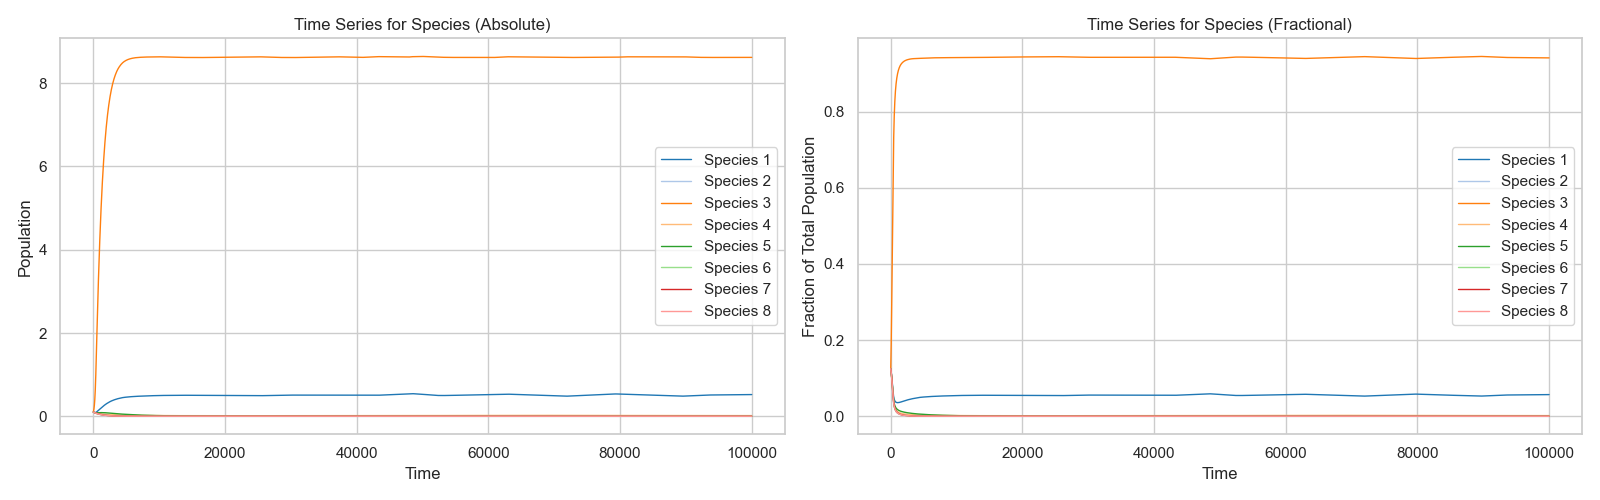

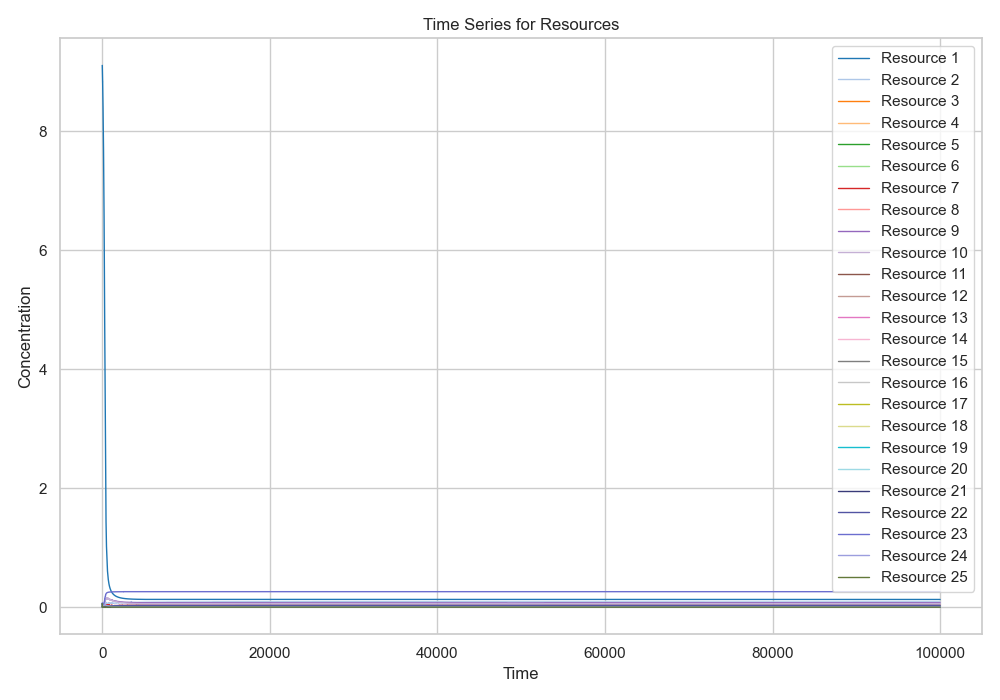

In [36]:
# wrapper for the visualization functions in shared/visualize.py file

def vis_wm_wrapper(N, R):
    """
    Wrapper function to display plots inline in a Jupyter notebook and then delete the files.
    """
    # Create a temporary directory
    with tempfile.TemporaryDirectory() as tmpdirname:
        # Call the original function
        visualize.vis_wm(N, R, tmpdirname)
        
        # Paths to the temporary plot files
        plot_path = os.path.join(tmpdirname, 'wmN.png')
        plot_path_R = os.path.join(tmpdirname, 'wmR.png')
        
        # Display the plots
        for plot in [plot_path, plot_path_R]:
            if os.path.exists(plot):
                img = Image.open(plot)
                display(img)

vis_wm_wrapper(N_fin,R_fin[1:])

## Perform the mapping

In [37]:
# calculate matrices for mapping
grad_mat=grad_i_alpha(R_fin[-1,:],param,mat)
sig=sigma(R_fin[-1,:],param)
f_mat=f_i_alpha(R_fin[-1,:],param,mat)


# intrinsic growth rates
g_LV = np.zeros((n_s))
for i in range(n_s):
    g_LV[i]=np.dot(grad_mat[i],sig)

# interaction matrix
A_int=np.zeros((n_s,n_s))
for i in range(n_s):
    for j in range(n_s):
        A_int[i,j]=np.dot(grad_mat[i],f_mat[j])

In [38]:
# simulate LV with these parameters

def LV_model(t,y,r0,A):

    sp_abund = y

    # Set abundances to zero if they are less than a threshold
    #sp_abund[sp_abund < 1e-10] = 0

    dsdt = [sp_abund[alpha]*(r0[alpha] + np.dot(A[alpha,:],sp_abund)) for alpha in range(n_s)]
    
    return dsdt

In [39]:
# Solve Lotka-Volterra dynamics
lv_args = (g_LV,A_int)
t_span_lv = (0,600)
t_eval_lv = np.arange(t_span_lv[0],t_span_lv[1],0.001)
solLV = solve_ivp(fun=LV_model, t_span=t_span_lv, y0=np.ones((n_s))*0.1, t_eval=t_eval_lv, args=lv_args)

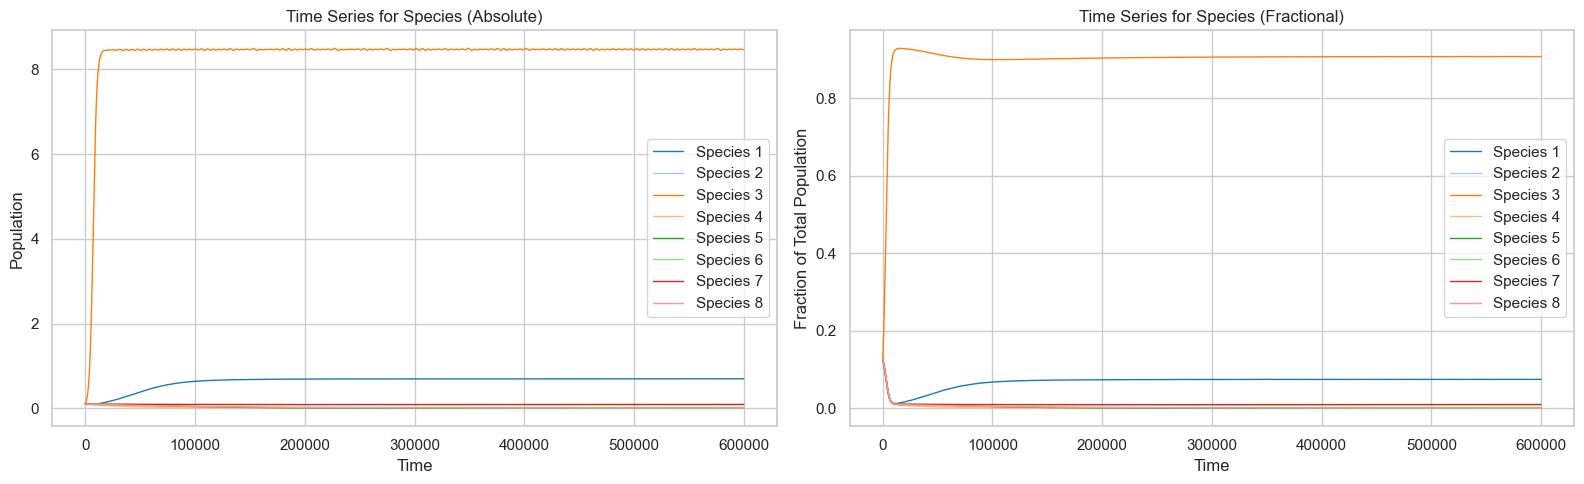

In [40]:

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Absolute abundances
axs[0].set_title("Time Series for Species (Absolute)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Population")

colors = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)

for i in range(solLV.y.shape[0]):
    axs[0].plot(solLV.y[i,:], label=f'Species {i+1}', color=colors[i], linewidth=1)
axs[0].legend()
axs[0].grid(True)

# Fractional abundances
axs[1].set_title("Time Series for Species (Fractional)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Fraction of Total Population")

total_population = np.sum(solLV.y, axis=0, keepdims=True)
fractional_abundance = np.divide(solLV.y, total_population, where=total_population!=0)

for i in range(solLV.y.shape[0]):
    axs[1].plot(fractional_abundance[i,:], label=f'Species {i+1}', color=colors[i], linewidth=1)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()



In [41]:
N_fin[-1,:]-solLV.y[:,-1]

array([-1.74835628e-01, -5.22035188e-04,  1.57602497e-01,  1.62549014e-02,
       -1.81063598e-05, -8.17019755e-02, -9.07530226e-02, -1.01150411e-03])

In [42]:
R_fin[-1,:]-R_fin[-5,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])